In [124]:
import re
import itertools
import pandas
import numpy as np
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score, StratifiedKFold
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel
import xgboost
from xgboost import XGBClassifier

***Read In Data***

In [2]:
file1 = open('chess_fens3.txt')
data = file1.readlines()
file2 = open('chess_results2.txt')
targets = file2.readlines()

In [3]:
print(len(data), len(targets))

22070 20500


***Feature Engineering***

In [4]:
engineered_data = []

for line in data:
    line_features = []
    position = line[:line.index(' ')]
    
    #Split the position into individual squares
    rows = position.split('/')
    expanded_position = []
    for row in rows:
        expanded_row = ''
        for char in row:
            if char.isdigit():
                for i in range(int(char)):
                    expanded_row += ' '
            else:
                expanded_row += char
        expanded_row = [char for char in expanded_row]
        expanded_position += expanded_row
    line_features += expanded_position 
    
    #Count number of each type of piece
    qs = position.count('q')
    Qs = position.count('Q')
    rs = position.count('r')
    Rs = position.count('R')
    pieces = position.count('b')+position.count('n')
    Pieces = position.count('B')+position.count('N')
    pawns = position.count('p')
    Pawns = position.count('P')
    developed_pawns = expanded_position[48:].count('p')
    Developed_Pawns = expanded_position[:16].count('P')
    
    line_features.append(qs)
    line_features.append(Qs)
    line_features.append(rs)
    line_features.append(Rs)
    line_features.append(pieces)
    line_features.append(Pieces)
    line_features.append(pawns)
    line_features.append(Pawns)
    line_features.append(9*(Qs-qs)+5*(Rs-rs)+3*(Pieces-pieces)+(Pawns-pawns)) #material advantage
    line_features.append(developed_pawns)
    line_features.append(Developed_Pawns)
    line_features.append(qs+Qs+rs+Rs+pieces+Pieces+pawns+Pawns)
    
    engineered_data.append(line_features)

engineered_data = np.array([np.array(x) for x in engineered_data])

In [5]:
engineered_data.shape

(22070, 76)

***Process Categorical Data***

In [6]:
les = []
le = LabelEncoder()
le.fit(engineered_data.T[0])
processed_data = le.transform(engineered_data.T[0])
les.append(le)

for col in engineered_data.T[1:64]:
    le = LabelEncoder()
    le.fit(col)
    processed_col = le.transform(col)
    processed_data = np.vstack((processed_data, processed_col))
    les.append(le)

processed_data = np.vstack((processed_data, engineered_data.T[64:]))
processed_data = processed_data.T

In [7]:
print(processed_data.shape, len(les))

(22070, 76) 64


***Oversampling and Train-Test Split***

In [84]:
ys = np.array(targets)
xs = processed_data[:ys.shape[0]]

test_xs = xs[int(0.9*xs.shape[0]):]
test_ys = ys[int(0.9*xs.shape[0]):]
train_xs = xs[:int(0.9*xs.shape[0])]
train_ys = ys[:int(0.9*xs.shape[0])]

ada = ADASYN(random_state = 1729)
train_xs, train_ys = ada.fit_resample(train_xs.astype(np.int), train_ys)

***Train Model***

In [85]:
clf = RandomForestClassifier(n_estimators = 1000, random_state = 42)
clf.fit(train_xs, train_ys)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

***Check Accuracy (best: 69%)***

In [86]:
pred = clf.predict(test_xs)
total = test_ys.shape[0]
correct = len([x for x in pred==test_ys if x==True])
print("Out of a total of %d samples, %d were correct" %(total, correct))

Out of a total of 2050 samples, 1416 were correct


***Plot Confusion Matrix (best accuracies: White = 79%, Black = 62%, Draw = 61%)***

Normalized confusion matrix
[[0.77179487 0.09230769 0.13589744]
 [0.16346154 0.68846154 0.14807692]
 [0.24666667 0.14533333 0.608     ]]


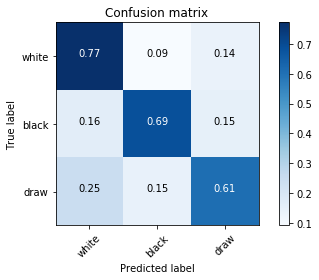

In [87]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

cnf_matrix = confusion_matrix(test_ys, pred)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['white', 'black', 'draw'], normalize=True)

In [92]:
print(pred.tolist().count('0\n'), pred.tolist().count('1\n'), pred.tolist().count('2\n'))
print(test_ys.tolist().count('0\n'), test_ys.tolist().count('1\n'), test_ys.tolist().count('2\n'))

872 539 639
780 520 750


In [95]:
clf.feature_importances_

array([0.0063577 , 0.00532543, 0.00626794, 0.00727498, 0.00713167,
       0.01197662, 0.00731028, 0.00678035, 0.00832936, 0.01167249,
       0.00849524, 0.00945885, 0.01033327, 0.01399831, 0.01502124,
       0.00987787, 0.00834815, 0.01089388, 0.01098687, 0.01185722,
       0.01234015, 0.01337929, 0.01129504, 0.01084845, 0.00976246,
       0.01036044, 0.01099058, 0.01373983, 0.01299068, 0.01062826,
       0.01216535, 0.01093191, 0.00923865, 0.01009464, 0.01106351,
       0.01176875, 0.01392505, 0.01094134, 0.01112796, 0.01171119,
       0.00908105, 0.0099612 , 0.00982832, 0.008808  , 0.01169048,
       0.01126241, 0.01456098, 0.01157289, 0.00938505, 0.0104347 ,
       0.00841809, 0.00795635, 0.00918692, 0.01458052, 0.01350831,
       0.0105714 , 0.00606804, 0.00466765, 0.00556545, 0.00595418,
       0.00576706, 0.00783308, 0.00876036, 0.00583729, 0.00774002,
       0.00832586, 0.01274107, 0.01254806, 0.01699278, 0.01932983,
       0.03626041, 0.04023734, 0.15808581, 0.00351249, 0.00487

***Try Gradient Boosters (Best Accuracy: 67%)***

In [90]:
clf2 = XGBClassifier(learning_rate = 0.1, n_estimators = 1000, max_depth = 2, reg_beta = 10, random_state = 42)
clf2.fit(train_xs, train_ys)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=2, min_child_weight=1, missing=None,
       n_estimators=1000, n_jobs=1, nthread=None,
       objective='multi:softprob', random_state=42, reg_alpha=0,
       reg_beta=10, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)

Out of a total of 2050 samples, 1346 were correct
Normalized confusion matrix
[[0.69487179 0.11538462 0.18974359]
 [0.12692308 0.66538462 0.20769231]
 [0.216      0.17333333 0.61066667]]


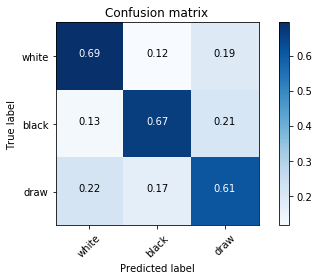

In [91]:
pred2 = clf2.predict(test_xs)
total = test_ys.shape[0]
correct = len([x for x in pred2==test_ys if x==True])
print("Out of a total of %d samples, %d were correct" %(total, correct))

cnf_matrix = confusion_matrix(test_ys, pred2)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['white', 'black', 'draw'], normalize=True)

In [96]:
print(pred2.tolist().count('0\n'), pred2.tolist().count('1\n'), pred2.tolist().count('2\n')) #white wins, black wins, draws

770 566 714


In [97]:
clf2.feature_importances_

array([0.01205836, 0.00865553, 0.01124946, 0.01071156, 0.01374696,
       0.02310166, 0.011319  , 0.02199601, 0.01145144, 0.01181581,
       0.009606  , 0.01686651, 0.00928612, 0.01580484, 0.01456988,
       0.00795328, 0.00710546, 0.00906123, 0.0117458 , 0.01067681,
       0.00824801, 0.01292689, 0.00893072, 0.01220911, 0.01178563,
       0.00997896, 0.00997221, 0.00758169, 0.00617388, 0.00806711,
       0.02212675, 0.01054332, 0.00813957, 0.00717881, 0.00565387,
       0.00702965, 0.01217937, 0.00674058, 0.00873534, 0.01108822,
       0.00983109, 0.00606898, 0.00791201, 0.008422  , 0.01074319,
       0.00719538, 0.0133123 , 0.01248342, 0.00926519, 0.00792885,
       0.01096946, 0.00881835, 0.01202467, 0.01364481, 0.01151558,
       0.00775911, 0.00810175, 0.00756941, 0.00560765, 0.00969625,
       0.00899666, 0.01007294, 0.01031467, 0.01276225, 0.00804781,
       0.02452754, 0.02981753, 0.01112635, 0.00889227, 0.01553193,
       0.03339991, 0.02312885, 0.1077862 , 0.01973493, 0.02494

In [98]:
def predict_result(fen, classifier = clf):
    global les
    
    line_features = []
    position = fen[:fen.index(' ')]
    
    #Split the position into individual squares
    rows = position.split('/')
    expanded_position = []
    for row in rows:
        expanded_row = ''
        for char in row:
            if char.isdigit():
                for i in range(int(char)):
                    expanded_row += ' '
            else:
                expanded_row += char
        expanded_row = [char for char in expanded_row]
        expanded_position += expanded_row
    line_features += expanded_position
    
    #Count number of each type of piece
    qs = position.count('q')
    Qs = position.count('Q')
    rs = position.count('r')
    Rs = position.count('R')
    pieces = position.count('b')+position.count('n')
    Pieces = position.count('B')+position.count('N')
    pawns = position.count('p')
    Pawns = position.count('P')
    developed_pawns = expanded_position[48:].count('p')
    Developed_Pawns = expanded_position[:16].count('P')
    
    line_features.append(qs)
    line_features.append(Qs)
    line_features.append(rs)
    line_features.append(Rs)
    line_features.append(pieces)
    line_features.append(Pieces)
    line_features.append(pawns)
    line_features.append(Pawns)
    line_features.append(9*(Qs-qs)+5*(Rs-rs)+3*(Pieces-pieces)+(Pawns-pawns)) #material advantage
    line_features.append(developed_pawns)
    line_features.append(Developed_Pawns)
    line_features.append(qs+Qs+rs+Rs+pieces+Pieces+pawns+Pawns)
    
    #Convert to numeric
    transformed = []
    for i in range(64):
        transformed.append(les[i].transform([line_features[i]]))
    transformed += line_features[64:]
    transformed = np.array(transformed)
    transformed = transformed.reshape(1, -1)
    
    #Predict
    pred = classifier.predict(transformed)
    
    #Print prediction
    if pred == '0\n':
        print("White is predicted to win")
    elif pred == '1\n':
        print("Black is predicted to win")
    else:
        print("The predicted result is a draw")
    
    #get "score" (expected points earned by white where win = 1 point and draw = 0.5 points)
    probabilities = classifier.predict_proba(transformed)
    score = probabilities[0][0] + 0.5*probabilities[0][2]
    print("Score: ", score) #a score of > 0.5 favours white. < 0.5 favours black


In [99]:
predict_result("3r1qk1/1pp3pp/p1p2p2/8/7P/2P2P2/P1P2nPK/R3R3 b - - 2 20")

The predicted result is a draw
Score:  0.482


***Cross-Validation and Statistical Tests***

In [125]:
scores = cross_val_score(clf, train_xs, train_ys, cv = StratifiedKFold(n_splits = 10))

In [129]:
print("scores:", scores)
print("95%% confidence interval: %f (+/- %f)" %(np.mean(scores), np.std(scores)))

scores: [0.70770722 0.68783325 0.66989821 0.70334464 0.74151309 0.67992241
 0.68122271 0.78214459 0.82920912 0.7845706 ]
95% confidence interval: 0.726737 (+/- 0.052010)


In [130]:
class MaterialClassifier():
    '''classifier based off of material advantage. Assumes material advantage is the index i feature in the data.'''
    def __init__(self, win_boundary, i):
        self.win_boundary = win_boundary
        self.i = i
    
    def fit(self, X, y):
        return self
    
    def predict(self, X):
        return np.array(['0\n' if int(x[self.i]) >= self.win_boundary else '1\n' if int(x[self.i]) <= -self.win_boundary else '2\n' for x in X])
    
    def score(self, X, y):
        pred = self.predict(X)
        total = y.shape[0]
        correct = len([x for x in pred==y if x==True])
        return correct / total
    
    def get_params(self, deep = False):
        return {'win_boundary':self.win_boundary, 'i':self.i}
    
    
material_clf = MaterialClassifier(1, -4)
material_scores = cross_val_score(material_clf, xs, ys, cv = KFold(n_splits = 10))
print("scores:", material_scores)
print("95%% confidence interval: %f (+/- %f)" %(np.mean(material_scores), np.std(material_scores)))
        

scores: [0.62682927 0.64585366 0.6        0.66536585 0.65804878 0.59853659
 0.62146341 0.64829268 0.61365854 0.6595122 ]
95% confidence interval: 0.633756 (+/- 0.023650)


In [131]:
random_scores = [0.33]*10
print("result when compared to random predictions:", ttest_rel(scores, random_scores))
print("result when compared to predictions based on material:", ttest_rel(scores, material_scores))

result when compared to random predictions: Ttest_relResult(statistic=22.88431783979324, pvalue=2.7590005585181213e-09)
result when compared to predictions based on material: Ttest_relResult(statistic=5.539409547779677, pvalue=0.00036132365987764703)
